In [429]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

In [430]:
# Load a specific output folder (recommended) OR auto-pick newest
from pathlib import Path
import time

# Option A (recommended): point directly to the newest run folder
OUTPUT_DIR = Path(r"C:\Users\braid\OneDrive\Desktop\Bouncing Ball\outputs\hula_hoop_2026-01-23_18-37-19")

# Basic guardrails
if not OUTPUT_DIR.exists():
    raise FileNotFoundError(f"OUTPUT_DIR does not exist: {OUTPUT_DIR}")

q_path = OUTPUT_DIR / "q_save.npy"
u_path = OUTPUT_DIR / "u_save.npy"
X_path = OUTPUT_DIR / "X_save.npy"
for p in [q_path, u_path, X_path]:
    if not p.exists():
        raise FileNotFoundError(f"Missing required file: {p}")

print("Using output:", OUTPUT_DIR)
print("q_save.npy mtime:", time.ctime(q_path.stat().st_mtime))
print("u_save.npy mtime:", time.ctime(u_path.stat().st_mtime))
print("X_save.npy mtime:", time.ctime(X_path.stat().st_mtime))

q = np.load(q_path)
u = np.load(u_path)
X = np.load(X_path)

params_path = OUTPUT_DIR / "params.json"
params = json.loads(params_path.read_text(encoding="utf-8")) if params_path.exists() else {}

print("q0 from file =", q[:, 0])
print("u0 from file =", u[:, 0])
if "q0" in params:
    print("params.json q0 =", params["q0"])
if "u0" in params:
    print("params.json u0 =", params["u0"])
for k in ["x0_input", "y0_input", "theta0_input", "omega0_input", "start_in_contact", "enforce_gap_distance"]:
    if k in params:
        print(f"params.json {k} =", params[k])

print("q shape:", q.shape)
print("u shape:", u.shape)
print("X shape:", X.shape)

# Show a couple later states to confirm runs differ even when q0 matches
print("q[:,1] =", q[:, 1])
print("q[:,10] =", q[:, 10])

Using output: C:\Users\braid\OneDrive\Desktop\Bouncing Ball\outputs\hula_hoop_2026-01-23_18-37-19
q_save.npy mtime: Fri Jan 23 18:37:51 2026
u_save.npy mtime: Fri Jan 23 18:37:51 2026
X_save.npy mtime: Fri Jan 23 18:37:51 2026
q0 from file = [-0.04011976  0.1         3.14159265]
u0 from file = [0.  0.  0.5]
params.json q0 = [-0.04011976047904192, 0.1, 3.141592653589793]
params.json u0 = [0.0, 0.0, 0.5]
params.json x0_input = 0.0
params.json y0_input = 0.0
params.json theta0_input = 3.141592653589793
params.json omega0_input = 0.5
params.json start_in_contact = True
params.json enforce_gap_distance = True
q shape: (3, 1000)
u shape: (3, 1000)
X shape: (14, 1000)
q[:,1] = [-0.04011976  0.09998837  3.1447246 ]
q[:,10] = [-0.04078014  0.09884408  3.17168706]


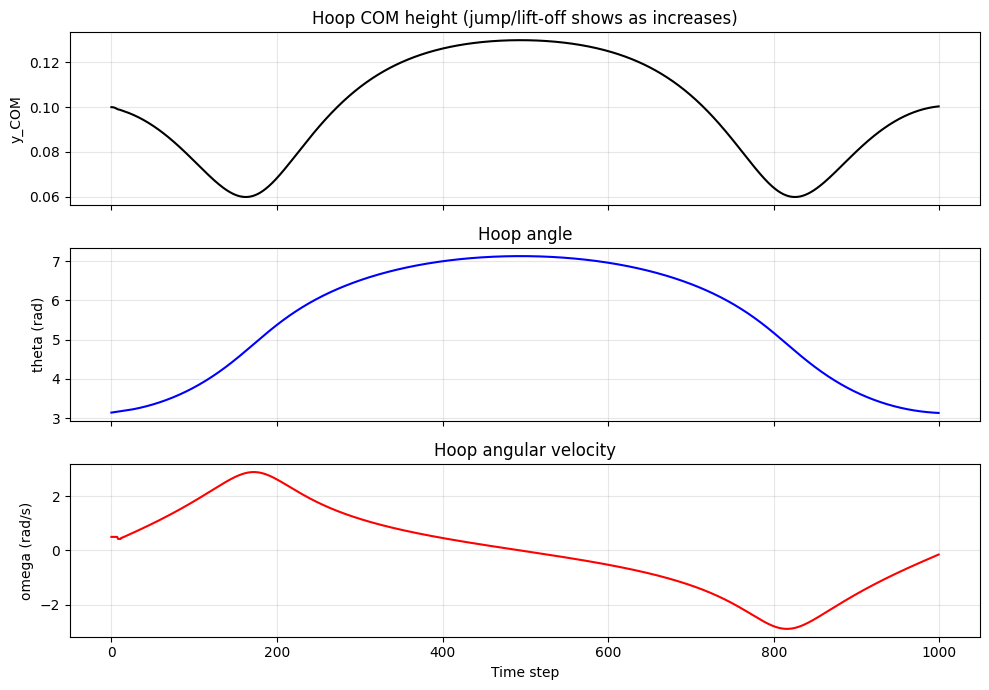

In [431]:
# Plot COM height, angle, and angular velocity
theta = q[2, :]
omega = u[2, :]
yC = q[1, :]

fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

axes[0].plot(yC, 'k-', linewidth=1.5)
axes[0].set_ylabel('y_COM')
axes[0].set_title('Hoop COM height (jump/lift-off shows as increases)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(theta, 'b-', linewidth=1.5)
axes[1].set_ylabel('theta (rad)')
axes[1].set_title('Hoop angle')
axes[1].grid(True, alpha=0.3)

axes[2].plot(omega, 'r-', linewidth=1.5)
axes[2].set_ylabel('omega (rad/s)')
axes[2].set_xlabel('Time step')
axes[2].set_title('Hoop angular velocity')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

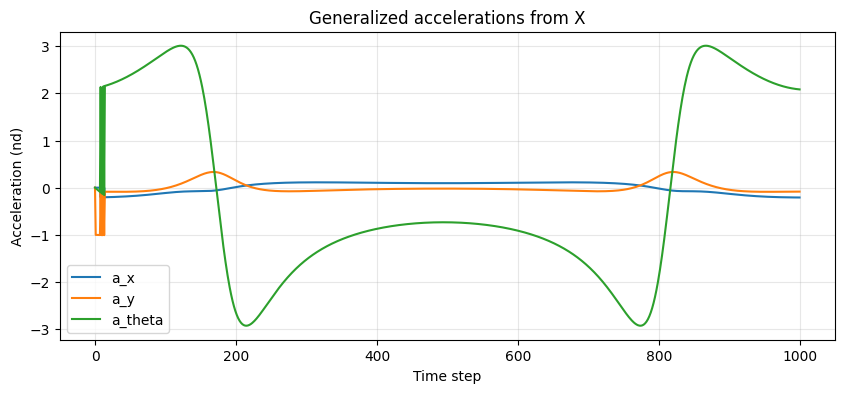

In [432]:
# Plot acceleration components from X array (a_x, a_y, a_theta) if present
if X.shape[0] >= 3:
    a_x = X[0, :]
    a_y = X[1, :]
    a_th = X[2, :]

    plt.figure(figsize=(10, 4))
    plt.plot(a_x, label='a_x')
    plt.plot(a_y, label='a_y')
    plt.plot(a_th, label='a_theta')
    plt.xlabel('Time step')
    plt.ylabel('Acceleration (nd)')
    plt.title('Generalized accelerations from X')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("X does not contain at least 3 acceleration components.")

[animation] Using output: C:\Users\braid\OneDrive\Desktop\Bouncing Ball\outputs\hula_hoop_2026-01-23_18-37-19
[animation] q[:,0] = [-0.04011976  0.1         3.14159265]
Saving animation to: C:\Users\braid\OneDrive\Desktop\Bouncing Ball\outputs\hula_hoop_2026-01-23_18-37-19\hulahoop_motion_hula_hoop_2026-01-23_18-37-19.gif
Saved.


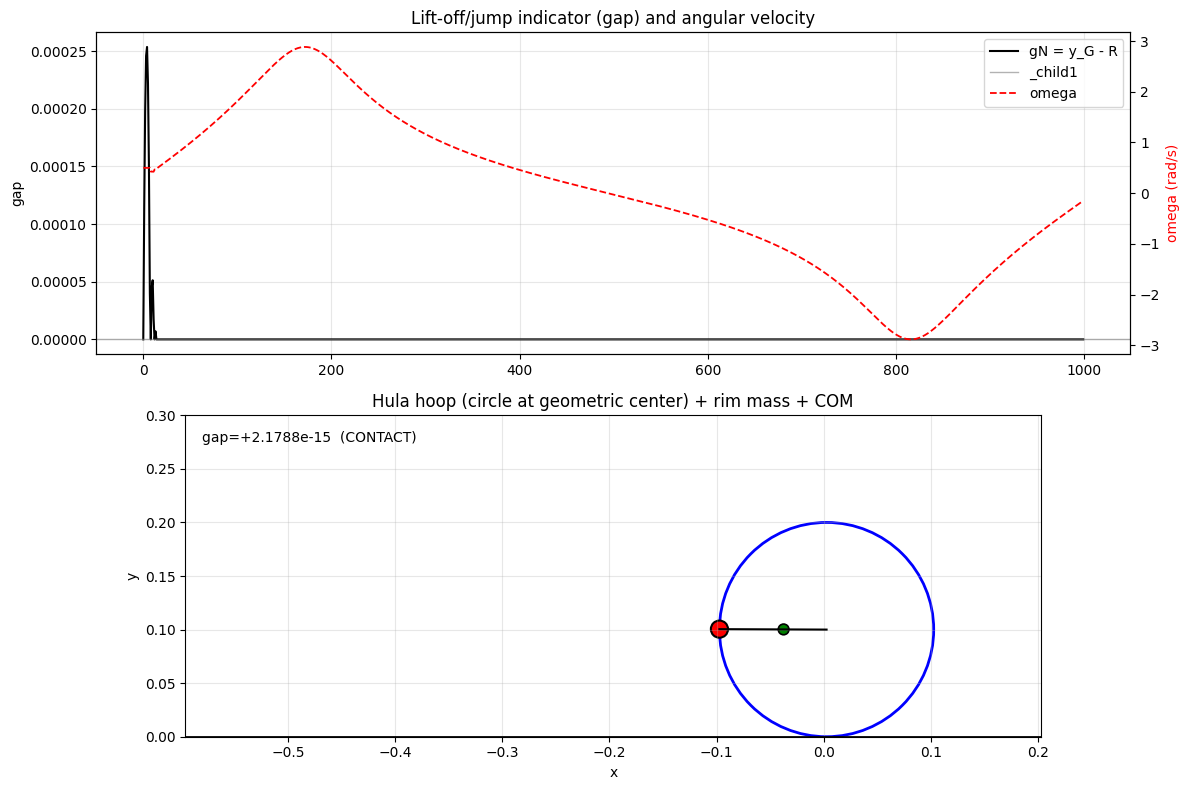

In [433]:
import matplotlib.animation as animation
from matplotlib.patches import Circle
from matplotlib.animation import PillowWriter

# Defensive reload: if you changed OUTPUT_DIR, rerunning *this* cell will still pick up the new data.
q = np.load(OUTPUT_DIR / "q_save.npy")
u = np.load(OUTPUT_DIR / "u_save.npy")
X = np.load(OUTPUT_DIR / "X_save.npy")
params_path = OUTPUT_DIR / "params.json"
params = json.loads(params_path.read_text(encoding="utf-8")) if params_path.exists() else {}
print("[animation] Using output:", OUTPUT_DIR)
print("[animation] q[:,0] =", q[:, 0])

# Parameters (prefer saved params.json)
R = float(params.get("R", 0.1))
d = float(params.get("d", 0.0))

xC = q[0, :]
yC = q[1, :]
theta = q[2, :]

# Geometric center G (circle center) from COM C
xG = xC - d * np.cos(theta)
yG = yC - d * np.sin(theta)

# Gap to ground (lift-off when > 0)
gN = yG - R

# Mass point on rim at +x_body relative to G
xM = xG + R * np.cos(theta)
yM = yG + R * np.sin(theta)

# ---- Figure layout ----
fig = plt.figure(figsize=(12, 8))

# 1) Time histories (gap and omega)
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(gN, 'k-', lw=1.5, label='gN = y_G - R')
ax1.axhline(0.0, color='gray', lw=1, alpha=0.6)
ax1.set_ylabel('gap')
ax1.grid(True, alpha=0.3)

ax1b = ax1.twinx()
ax1b.plot(u[2, :], 'r--', lw=1.3, label='omega')
ax1b.set_ylabel('omega (rad/s)', color='r')
ax1.set_title('Lift-off/jump indicator (gap) and angular velocity')

# Combined legend
lines = ax1.get_lines() + ax1b.get_lines()
labels = [ln.get_label() for ln in lines]
ax1.legend(lines, labels, loc='upper right')

# 2) Animation
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_aspect('equal')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Hula hoop (circle at geometric center) + rim mass + COM')
ax2.grid(True, alpha=0.3)

# axis limits from data
xmin = float(np.min(xG) - 2 * R)
xmax = float(np.max(xG) + 2 * R)
ymin = 0.0
ymax = float(max(np.max(yG) + 2 * R, 2 * R))
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)

# Ground line
ground_line, = ax2.plot([xmin, xmax], [0, 0], 'k-', lw=2)

# Hoop circle (centered at G)
hoop_circle = Circle((xG[0], yG[0]), R, fill=False, edgecolor='blue', linewidth=2)
ax2.add_patch(hoop_circle)

# Rim mass marker
mass_patch = Circle((xM[0], yM[0]), 0.08 * R if R > 0 else 0.01, color='red', ec='black', lw=1.5)
ax2.add_patch(mass_patch)

# COM marker
com_patch = Circle((xC[0], yC[0]), 0.05 * R if R > 0 else 0.01, color='green', ec='black', lw=1.2)
ax2.add_patch(com_patch)

# Radius line from G to rim mass
radius_line, = ax2.plot([xG[0], xM[0]], [yG[0], yM[0]], 'k-', lw=1.5)

# Text showing lift-off
status_text = ax2.text(0.02, 0.95, '', transform=ax2.transAxes, va='top')

def init():
    hoop_circle.center = (xG[0], yG[0])
    mass_patch.center = (xM[0], yM[0])
    com_patch.center = (xC[0], yC[0])
    radius_line.set_data([xG[0], xM[0]], [yG[0], yM[0]])
    status_text.set_text('')
    return hoop_circle, mass_patch, com_patch, radius_line, status_text

def animate(i):
    hoop_circle.center = (xG[i], yG[i])
    mass_patch.center = (xM[i], yM[i])
    com_patch.center = (xC[i], yC[i])
    radius_line.set_data([xG[i], xM[i]], [yG[i], yM[i]])
    status_text.set_text(f"gap={gN[i]:+.4e}  ({'AIR' if gN[i] > 1e-6 else 'CONTACT'})")
    return hoop_circle, mass_patch, com_patch, radius_line, status_text

step = 5
frames = range(0, q.shape[1], step)
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=20, blit=True)

# Optional: save GIF beside the output folder (unique per folder to avoid viewer caching)
gif_path = OUTPUT_DIR / f"hulahoop_motion_{OUTPUT_DIR.name}.gif"
print("Saving animation to:", gif_path)
writer = PillowWriter(fps=30)
anim.save(gif_path.as_posix(), writer=writer)
print("Saved.")

plt.tight_layout()
plt.show()

In [434]:
print(theta)

[3.14159265 3.1447246  3.14785603 3.15098648 3.15411544 3.15724242
 3.16036693 3.16348846 3.16635854 3.16902504 3.17168706 3.17434383
 3.17711882 3.18003848 3.18300767 3.18608047 3.18924074 3.19248485
 3.19581472 3.19922967 3.20273032 3.20631665 3.20998899 3.21374747
 3.21759234 3.2215238  3.22554208 3.22964739 3.23383996 3.23812004
 3.24248785 3.24694363 3.25148764 3.25612012 3.26084133 3.26565151
 3.27055095 3.27553989 3.28061861 3.2857874  3.29104651 3.29639624
 3.30183688 3.30736871 3.31299202 3.31870712 3.32451431 3.33041389
 3.33640617 3.34249146 3.34867009 3.35494236 3.36130862 3.36776917
 3.37432436 3.38097452 3.38771998 3.39456109 3.40149819 3.40853163
 3.41566176 3.42288894 3.43021352 3.43763586 3.44515633 3.45277529
 3.46049312 3.46831017 3.47622684 3.4842435  3.49236052 3.50057829
 3.5088972  3.51731763 3.52583998 3.53446463 3.54319198 3.55202242
 3.56095636 3.5699942  3.57913633 3.58838315 3.59773509 3.60719253
 3.61675588 3.62642556 3.63620197 3.64608552 3.65607661 3.6661